In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils
%matplotlib inline

## Imágenes desde ficheros

ref https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### descargamos imágenes de dos queries en google

In [2]:
!pip install google_images_download

  Using cached https://files.pythonhosted.org/packages/80/d6/4294f0b4bce4de0abf13e17190289f9d0613b0a44e5dd6a7f5ca98459853/selenium-3.141.0-py2.py3-none-any.whl


In [3]:
downloads = "/tmp/downloads"
traintest_imgs = "/tmp/imgs"

train_pct = .7

In [4]:
!rm -rf $downloads
!mkdir $downloads

In [5]:
cfg="""
{
    "Records": [
        {
            "keywords": "sleeping_yellow_cat",
            "format": "jpg",
            "limit": 100,
            "type": "photo",
            "size": "medium",
            "output_directory": "%s"
        },
        {
            "keywords": "panzerotti",
            "format": "jpg",
            "limit": 100,
            "type": "photo",
            "size": "medium", 
            "output_directory": "%s"
        }
    ]
}
"""%(downloads, downloads)

In [6]:
with open(downloads+"/cfg.txt", "w") as f:
    f.write(cfg)

In [7]:
!googleimagesdownload --config_file $downloads/cfg.txt


Item no.: 1 --> Item name = sleeping_yellow_cat
Evaluating...
Starting Download...
Completed Image ====> 1. sleeping-yellow-cat-jeng-suntorn-niamwhan.jpg
Completed Image ====> 2. 1.jpg
Completed Image ====> 3. sleeping-time-for-yellow-cat-748x522.jpg
Completed Image ====> 4. yellow-cat-sleeping-5184x3456_74515.jpg
Completed Image ====> 5. depositphotos_30089601-stock-photo-sleeping-yellow-cat.jpg
Completed Image ====> 6. new-simulation-breathing-cat-model-polyethylene-fur-yellow-sleeping-cat-doll-gift-about-23x19cm-2390.jpg
Completed Image ====> 7. 1.jpg
Completed Image ====> 8. depositphotos_62395939-stock-photo-yellow-cat-sleeping.jpg
Completed Image ====> 9. depositphotos_104167598-stock-photo-yellow-cute-cat-sleeping-on.jpg
Completed Image ====> 10. rem-non-rem-sleep.jpg
Completed Image ====> 11. cat-3924741_960_720.jpg
Completed Image ====> 12. 10-pieces-a-lot-simulation-sleeping-cats-polyethylene-furs-mini-yellow-cat-models-funny-gift-about.jpg
Completed Image ====> 13. funny-sl

Completed Image ====> 99. additional_1a4b458ed33d0467d587f92659cb6720a11775c6-7.jpg

Errors: 1


Everything downloaded!
Total time taken: 129.263342142 Seconds

Item no.: 1 --> Item name = panzerotti
Evaluating...
Starting Download...
Completed Image ====> 1. panzerotti_1600x1200.jpg
Completed Image ====> 2. panzerotto_main_zestyfood_13.jpg
Completed Image ====> 3. ckn-e48-chicken-panzerotti-006.jpg
Completed Image ====> 4. panzerotti.jpg
Completed Image ====> 5. 533_60c5837c9de35842547e268ebcd133d8.jpeg
Completed Image ====> 6. panzerotti.jpg
Completed Image ====> 7. 31burnerpanzerotti-articlelarge.jpg
Completed Image ====> 8. panzerotti-pugliesi-la-ricetta-tradizionale.jpg
Completed Image ====> 9. panzerottis-y-palitos-al-ajo-precocidos-negocios-o-reuniones-d_nq_np_882505-mpe26107022740_102017-f.jpg
Completed Image ====> 10. 2902_panzerottipizzasnack.jpg
Completed Image ====> 11. panzerotti-fritti.jpg
Completed Image ====> 12. panzerotti-03-copertina.jpg
Completed Image ====> 13. 154

### revisamos las imágenes y eliminamos las defectuosas

In [8]:
from skimage import io
files = !find $downloads -type f
for fname in files:
    if fname!=downloads+"/cfg.txt":
        print ".",
        try:
            io.imread(fname)
        except:
            print "\nremoving",fname,"as cannot be read\n"
            !rm '$fname'

. . . . . . . . . . . . . . . 
removing /tmp/downloads/sleeping_yellow_cat/23. new-simulation-sleeping-cat-model-toy-resin-fur-yellow-cat-model-gift-25cm-0569.jpg as cannot be read

. . . . . . . . . 
removing /tmp/downloads/sleeping_yellow_cat/6. new-simulation-breathing-cat-model-polyethylene-fur-yellow-sleeping-cat-doll-gift-about-23x19cm-2390.jpg as cannot be read

. . . . . . . . . . . 
removing /tmp/downloads/sleeping_yellow_cat/54. simulation-sleeping-cat-lifelike-handicraft-yellow-cat-doll-gift-about-29x10x31cm.jpg as cannot be read

. . . . . . . . . . . . . 
removing /tmp/downloads/sleeping_yellow_cat/37. simulation-yellow-cat-model-24x20cm-plastic-furs-sleeping-cat-handicraft-toy-xmas-gift-w5718.jpg as cannot be read

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
removing /tmp/downloads/sleeping_yellow_cat/85. mini-simulation-yellow-cat-cute-sleeping-cat-doll-car-decoration-gift-doll-about-10cm.jpg as cannot be read

. . . . . . . . . . . . .

### organizamos las imágenes en train y en test

In [9]:
classdirs = !find $downloads -type d
classdirs = [i.split("/")[-1] for i in classdirs if i!=downloads]
print classdirs

['sleeping_yellow_cat', 'panzerotti']


In [10]:
!rm -rf $traintest_imgs

In [11]:
classdir = classdirs[0]
files = !find $downloads/$classdir -type f
files = np.r_[files]

from sklearn.model_selection import train_test_split
y_train,y_test = train_test_split(files, test_size=.50)
print y_train.shape,y_test.shape

(47,) (47,)


In [132]:
for classdir in classdirs:
    print classdir
    print "    splitting files ... ",
    files = !find $downloads/$classdir -type f
    files = np.r_[files]
    n_train = int((len(files))/2*train_pct)
    #from sklearn.model_selection import train_test_split
    #files_train,files_test = train_test_split(files, test_size=.5)
    #print y_train.shape,y_test.shape
    files_train = files[:n_train]
    files_test  = files[n_train:]
    !mkdir -p $traintest_imgs/train/$classdir
    !mkdir -p $traintest_imgs/test/$classdir
    print "copying files"
    for f in files_train:
        !cp '$f' $traintest_imgs/train/$classdir
    for f in files_test:
        !cp '$f' $traintest_imgs/test/$classdir

sleeping_yellow_cat
    splitting files ...  copying files
panzerotti
    splitting files ...  copying files


In [101]:
print n_train

33


### sanity check 1

In [46]:
for classdir in classdirs:
    print classdir
    files = !find  $traintest_imgs/train/$classdir -type f
    print "      ",len(files)/2, "train images"
    files = !find  $traintest_imgs/test/$classdir -type f
    print "      ",len(files)/2, "test images"

sleeping_yellow_cat
       42 train images
       36 test images
panzerotti
       43 train images
       37 test images


### sanity check 2

see [ImageGenerator](https://keras.io/preprocessing/image/)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [133]:
datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
batch_size = 10
img_size = 32
train_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/train",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

test_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/test",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

Found 172 images belonging to 2 classes.


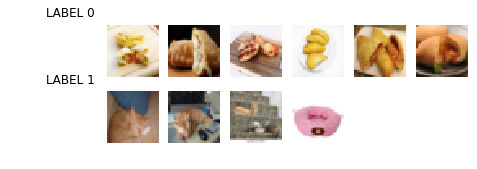

In [48]:
for imgs,labels in train_generator_fn():
    if np.random.random()>.5:
        break
reload(mlutils)        
mlutils.show_labeled_image_mosaic(imgs, labels)

# Primer modelo

Resolución de 32
capa convolucional de 15 filtros de 10 x 10
Capa densa de 32 neuronas


### train keras!!!

In [134]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(10,10), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    #layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [135]:
num_classes = len(classdirs)
model = get_conv_model_A(num_classes, img_size=img_size)

model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=5,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)


using 2 classes
Found 182 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 22s 216ms/step - loss: 0.6411 - acc: 0.6580 - val_loss: 0.5393 - val_acc: 0.7273
Epoch 2/5
100/100 [==============================] - 18s 177ms/step - loss: 0.4733 - acc: 0.7769 - val_loss: 0.4276 - val_acc: 0.8106
Epoch 3/5
100/100 [==============================] - 18s 175ms/step - loss: 0.4205 - acc: 0.7781 - val_loss: 0.6337 - val_acc: 0.6869
Epoch 4/5
100/100 [==============================] - 19s 185ms/step - loss: 0.3964 - acc: 0.8150 - val_loss: 0.4817 - val_acc: 0.7753
Epoch 5/5
100/100 [==============================] - 17s 173ms/step - loss: 0.2667 - acc: 0.8879 - val_loss: 0.2724 - val_acc: 0.8864


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 23, 15)        4515      
_________________________________________________________________
flatten (Flatten)            (None, 7935)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                253952    
_________________________________________________________________
output_1 (Dense)             (None, 2)                 66        
Total params: 258,533
Trainable params: 258,533
Non-trainable params: 0
_________________________________________________________________


### predictions

In [113]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
    
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)


Found 187 images belonging to 2 classes.


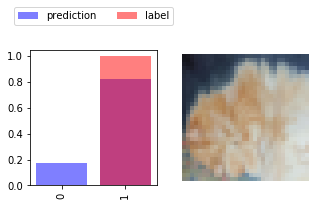

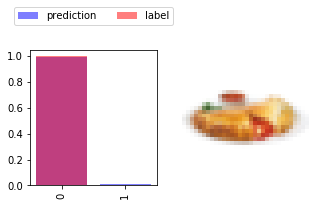

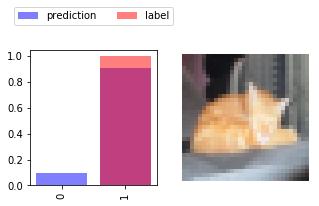

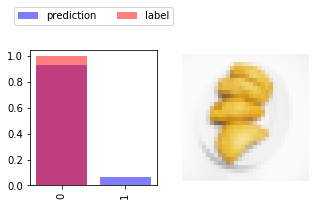

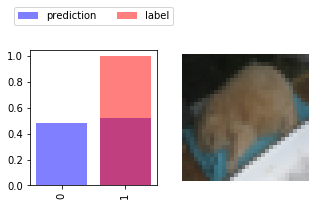

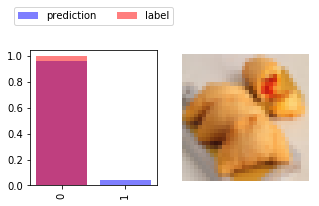

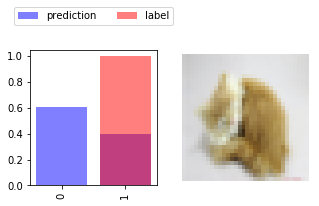

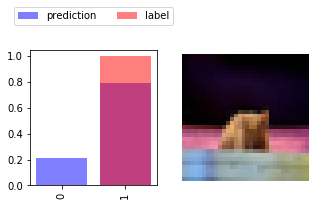

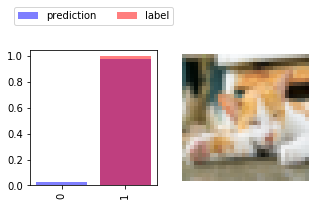

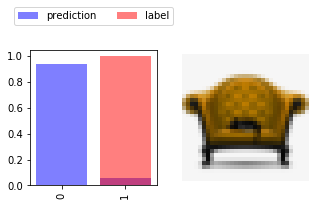

In [114]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
preds = model.predict(x)
mlutils.show_preds(x, y, preds)

# Segundo modelo

# Drop out

In [137]:
def get_conv_model_B(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(10,10), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(32, activation=tf.nn.relu)(layers)
    #layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [138]:
num_classes = len(classdirs)
model_B = get_conv_model_B(num_classes, img_size=img_size)

model_B.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=5,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)

using 2 classes
Found 182 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 21s 210ms/step - loss: 0.6409 - acc: 0.6381 - val_loss: 0.5188 - val_acc: 0.7929
Epoch 2/5
100/100 [==============================] - 18s 184ms/step - loss: 0.5645 - acc: 0.7330 - val_loss: 0.5176 - val_acc: 0.7500
Epoch 3/5
100/100 [==============================] - 17s 167ms/step - loss: 0.4502 - acc: 0.7810 - val_loss: 0.3353 - val_acc: 0.8687
Epoch 4/5
100/100 [==============================] - 18s 183ms/step - loss: 0.3442 - acc: 0.8550 - val_loss: 0.2618 - val_acc: 0.9040
Epoch 5/5
100/100 [==============================] - 17s 169ms/step - loss: 0.2279 - acc: 0.9111 - val_loss: 0.2201 - val_acc: 0.9091


In [23]:
model_B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 23, 15)        4515      
_________________________________________________________________
flatten (Flatten)            (None, 7935)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                507904    
_________________________________________________________________
output_1 (Dense)             (None, 2)                 130       
Total params: 512,549
Trainable params: 512,549
Non-trainable params: 0
_________________________________________________________________


### Predictions


In [118]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
    
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)

Found 191 images belonging to 2 classes.


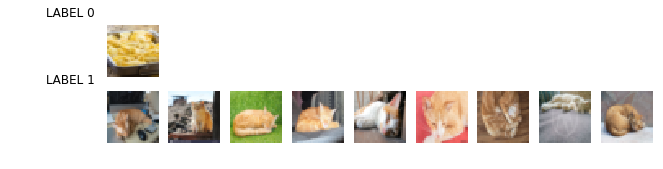

In [119]:
for imgs,labels in train_generator_fn():
    if np.random.random()>.5:
        break
reload(mlutils)        
mlutils.show_labeled_image_mosaic(imgs, labels)

Found 187 images belonging to 2 classes.


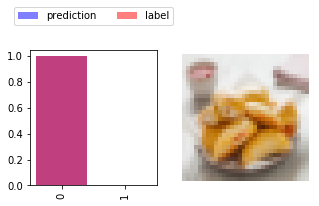

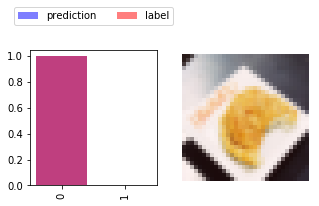

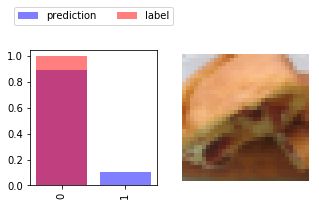

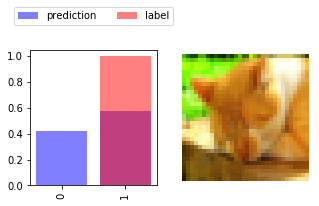

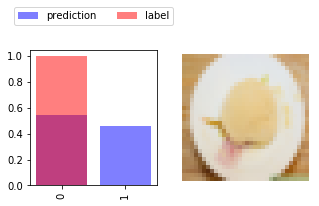

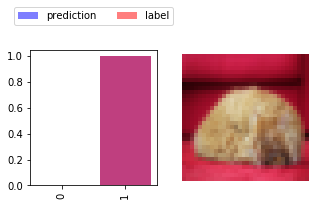

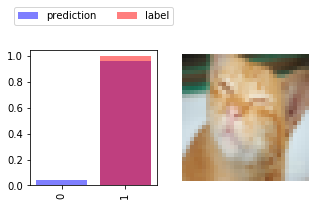

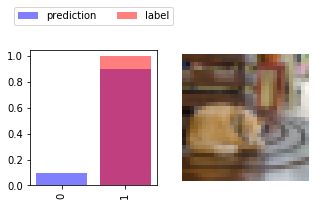

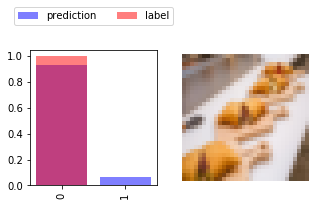

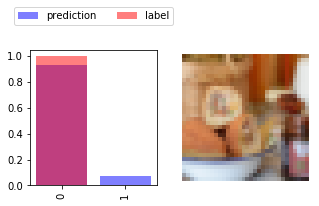

In [120]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
preds = model_B.predict(x)
mlutils.show_preds(x, y, preds)

# Tercer modelo

Resolución de 32
capa convolucional de 15 filtros de 10 x 10
capa convolucional de 10 filtros de 8 x 8
Capa densa de 32 neuronas
Drop out de 0.2

# Resolución de 64

In [140]:
def get_conv_model_C(num_classes, img_size=64, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(10,10), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(32, activation=tf.nn.relu)(layers)
    #layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [141]:
num_classes = len(classdirs)
model_C = get_conv_model_C(num_classes, img_size=img_size)

model_C.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=5,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)

using 2 classes
Found 182 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 21s 207ms/step - loss: 0.5708 - acc: 0.7050 - val_loss: 0.5449 - val_acc: 0.6970
Epoch 2/5
100/100 [==============================] - 17s 167ms/step - loss: 0.4586 - acc: 0.7870 - val_loss: 0.3772 - val_acc: 0.8384
Epoch 3/5
100/100 [==============================] - 16s 162ms/step - loss: 0.3149 - acc: 0.8739 - val_loss: 0.2733 - val_acc: 0.9116
Epoch 4/5
100/100 [==============================] - 18s 177ms/step - loss: 0.1644 - acc: 0.9490 - val_loss: 0.1526 - val_acc: 0.9621
Epoch 5/5
100/100 [==============================] - 17s 172ms/step - loss: 0.0770 - acc: 0.9830 - val_loss: 0.1538 - val_acc: 0.9520


In [26]:
model_C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 23, 15)        4515      
_________________________________________________________________
flatten (Flatten)            (None, 7935)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                507904    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
output_1 (Dense)             (None, 2)                 130       
Total params: 512,549
Trainable params: 512,549
Non-trainable params: 0
_________________________________________________________________


# Cuarto modelo

Resolución de 32
capa convolucional de 15 filtros de 10 x 10
Capa densa de 64 neuronas
Drop out de 0.2
Pooling
100 imágenes de test y 100 de preds

# 200 imágenes

In [143]:
for classdir in classdirs:
    print classdir
    print "    splitting files ... ",
    files = !find $downloads/$classdir -type f
    files = np.r_[files]
    n_train = int((len(files))*train_pct)
    #from sklearn.model_selection import train_test_split
    #files_train,files_test = train_test_split(files, test_size=.5)
    #print y_train.shape,y_test.shape
    files_train = files[:n_train]
    files_test  = files[n_train:]
    !mkdir -p $traintest_imgs/train/$classdir
    !mkdir -p $traintest_imgs/test/$classdir
    print "copying files"
    for f in files_train:
        !cp '$f' $traintest_imgs/train/$classdir
    for f in files_test:
        !cp '$f' $traintest_imgs/test/$classdir

sleeping_yellow_cat
    splitting files ...  copying files
panzerotti
    splitting files ...  copying files


In [144]:
datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
batch_size = 10
img_size = 64
train_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/train",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

test_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/test",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

In [145]:
def get_conv_model_D(num_classes, img_size=64, compile=True):
    #se aumenta primeto las imágenes y luego la res?
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(10,10), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(32, activation=tf.nn.relu)(layers)
    #layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [146]:
num_classes = len(classdirs)
model_D = get_conv_model_D(num_classes, img_size=img_size)

model_D.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=5,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)


using 2 classes
Found 182 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 29s 291ms/step - loss: 0.8039 - acc: 0.5741 - val_loss: 0.5452 - val_acc: 0.7222
Epoch 2/5
100/100 [==============================] - 26s 258ms/step - loss: 0.5184 - acc: 0.7601 - val_loss: 0.3930 - val_acc: 0.8030
Epoch 3/5
100/100 [==============================] - 27s 269ms/step - loss: 0.3529 - acc: 0.8510 - val_loss: 0.1863 - val_acc: 0.9571
Epoch 4/5
100/100 [==============================] - 27s 268ms/step - loss: 0.0998 - acc: 0.9750 - val_loss: 0.1434 - val_acc: 0.9722
Epoch 5/5
100/100 [==============================] - 27s 267ms/step - loss: 0.0226 - acc: 1.0000 - val_loss: 0.1427 - val_acc: 0.9798


Text(0,0.5,'accuracy in train')

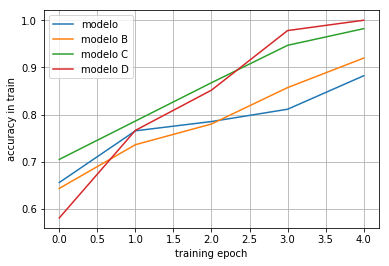

In [147]:
plt.plot(model.history.history["acc"], label="modelo"); #100 imágenes, resolución de 32, capa densa de 16 neuronas
plt.plot(model_B.history.history["acc"], label="modelo B"); #100 imágenes, resolución de 32, capa densa de 32 neuronas
plt.plot(model_C.history.history["acc"], label="modelo C"); #100 imágenes, capa densa de 32 neuronas, resolución de 64
plt.plot(model_D.history.history["acc"], label="modelo D"); #200 imágenes, capa densa de 32 neuronas, resolución de 64

plt.grid();
plt.legend();
plt.xlabel("training epoch")
plt.ylabel("accuracy in train")

## Descripción de los modelos

### Modelo A
#### Este modelo se realiza con 100 imágenes, cada una con una resolución de 32 y una capa densa de 16 neuronas

### Modelo B
#### En este modelo se cambia la capa densa a 32 neuronas

### Modelo C
#### En este modelo se incrementa la resolución de las imágenes a 64

### Modelo D
#### En este modelo se aumenta la cantidad de imágenes a 200 

Cose puede observar de la gráfica, al aumentar la complejidad de los modelos, se evicendia un incremento en la exactitud del entrenamiento a través de las épocas.